In [1]:
!pip install diffusers peft translate rembg -q

In [2]:
from diffusers import DiffusionPipeline, StableDiffusionPipeline
from diffusers.models.modeling_outputs import Transformer2DModelOutput
import torch
import peft
import transformers
from translate import Translator
from rembg import remove
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm
from PIL import Image, ImageDraw, ImageFont
from typing import Dict

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/diffusers/models/transformers/transformer_2d.py:34: FutureWarning: `Transformer2DModelOutput` is deprecated and will be removed in version 1.0.0. Importing `Transformer2DModelOutput` from `diffusers.models.transformer_2d` is deprecated and this will be removed in a future version. Please use `from diffusers.models.modeling_outputs import Transformer2DModelOutput`, instead.
  deprecate("Transformer2DModelOutput", "1.0.0", deprecation_message)
2024-06-16 16:12:25.007650: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-16 16:12:25.007750: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-16 16:12:25.133412: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] 

# Класс для создания модели

In [3]:
class Model:
    def __init__(self, 
                 weights: Dict[str, float], 
                 name_model: str = 'runwayml/stable-diffusion-v1-5'):
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.name_model = name_model
        self.load_model(weights)
    
    def load_model(self, weights: Dict[str, float]):
        self.pipe = StableDiffusionPipeline.from_pretrained(self.name_model, 
                                                            torch_dtype=torch.float16).to(self.device)
        self.pipe.safety_checker = None
        self.pipe.requires_safety_checker = False
        
        self.clear_adapters()

        for i, path_weights in enumerate(weights.keys()):
            self.pipe.load_lora_weights(path_weights, adapter_name=f'{i}')
            
        # Set new adapters and weights
        self.pipe.set_adapters([f'{i}' for i in range(len(weights))], adapter_weights=list(weights.values()))
        self.model = self.pipe
        
    def clear_adapters(self):
        if hasattr(self.pipe, 'adapter_manager'):
            self.pipe.adapter_manager.clear_adapters()
    
    
    def translator(self, prompt: str):
        translator = Translator(from_lang="ru", to_lang="en")
        result = translator.translate(prompt)
        return result
    
    def remove_bg(self, img: Image):
        return remove(img)
        
    def get_image(self,
                  prompt: str):
        prompt = self.translator(prompt)
        prompt = ','.join([obj.strip() for obj in prompt.split(',')]) +',isometric,claymorphism,3d render,icon,web icon'
        negative_prompt='pig, wool, draw, noise, real, text, picture, texture, detail'
        with torch.no_grad():
            img = self.model(prompt).images[0]
        return self.remove_bg(img)
#         return img


# Класс запросов к модели

In [4]:
class Request:
    def __init__(self, model):
        self.model = model
        
    def create_imgs(self,
                    n=1,
                    prompt=None,
                    channel=None,
                    product=None, 
                    dataset=None):
        # only prompt
        if prompt and (not product) and (not dataset):
            new_propmts = [prompt for i in range(n)]

        # only product
        elif product and (not prompt) and (not dataset):
            prompt_category = self.categories_prompts[product]

        # product and prompt
        elif prompt and product and (not dataset):
            prompt_category = self.categories_prompts[product]
            prompt_category = list(np.random.choice(prompt_category, n // 2))
            prompt_user = [prompt for i in range(n - n//2)]
            new_propmts = prompt_category + prompt_user
            np.random.shuffle(new_propmts)
            
        # only prompt
        else:
            new_propmts = [prompt for i in range(n)]

        
        def generator():
            for prompt_i in new_propmts:
                yield self.model.get_image(prompt_i)
        return generator()
#         for img in generator():
#             plt.imshow(img)
#             plt.show()
            
    categories_prompts = {
        'Обмен валюты': ['dollar,dollar bill,arrow,coin,rubble,exchange,currency exchange',
                         'ATM machine,blue,dollar,coin,gold goin,exchange,currency exchange',
                         'dollar,euro,ruble,currency notes from different countries,exchange',
                         'currency exchange,rasing chart,upwise trend,orange line,exchange rate,banknote',
                         'globe,blue planet,Earth,arrow,line,exchange,currency exchange',
                         'globe,planet,arrow,line,money exchange,swap,change,exchange,currency exchang,orange,light blue,deep blue,white',
                         'gold bag of money,banknote,dollars,money,currency exchange,ruble,euro,exchange rate,orange,light blue,deep blue,white',
                         'blue chart,line,rising trend,green arrow,profitable,bag of money,currency exchange,exchange,white,orange',
                         'chart,banknote,line,increasing trend,green arrow,profitable,blue bills,pack of blue bills,silver coins,currency exchange,exchange',
                         'coin,banknote,exchange,currency exchange,profitable,chart,increasing trend,percentage sign,green line',
                         'different currencies, banknotes, calculator, dynamic exchange rate figures,currency exchange, exchange'],
    
        'Кредит': ['stack,stack of coins,stack of bills,credit,profitably,loan,loan approval',
                   'handshake,contract,beneficial,bills,loan,loan approval',
                   'green confirmation check mark,loan,loan approval,bundle of bills,banknotes',
                   'contract,confirmation tick,handshake,loan,loan approval,bag of money',
                   'house keys,check mark,confirmation,loan,loan approval',
                   'travel,vacation,sea,sun,beach,beach umbrella,towel,beach flip-flops,blue,light blue,orange,white,green,yellow',
                   'travel,weekend,sea,sun,beach,chaise longue,beach chair,beach ball,blue,light blue,orange,white,green,yellow',
                   'student loan,education,university,graduate hat',
                   'credit,tuition,education,graduate hat,book,pen,blue,orange,white,black',
                   'new year,gift box,red box,white ribbon bow,Santa claus hat,snow,snowdrifts',
                   'new year,gift box,blue box,Christmas tree,snow,snowdrifts'],
    
        'Карта': ['card,gazprombank logo,mobile phone,smartphone,black phone',
                  'card,gazprombank logo,white smartphone,open screen,blue screen',
                  'credit card,gazprombank logo,gazpromcard,percent,percent sign,profitably,card',
                  'credit card,gazprombank logo,gift box,blue box,Christmas tree,snow,snowdrifts',
                  'credit card,gift box,orange box,white ribbon bow,percent sign,profitably',
                  'card,gazprombank logo,confetti,banknotes,gold coins',
                  'card,gazprombank logo,holiday,lightnings,festive hat,blue,white,silver,light blue',
                  'cards,two cards,white,black,silver chip,proection, 3D',
                  'cards,two cards,silver,gold,silver chip,proection, 3D',
                  'card,payment,terminal,ATM machine,black,while,silver',
                  'card,payment,terminal,contactless payment,online payment,attach the card to the terminal'],

        'Счета_вклады': ['safe,safety,safe locker,gold,gold coins',
                         'safe,safety,safe locker,silver,silver coins',
                         'safe,safety,safe locker,pack of banknotes,blue,money,bills',
                         'bank,money,bank building,coin,banknote,blue,white,light blue,orange',
                         'bank,bank building,banknotes,confetti,profitably',
                         'golden piggy bank,banknotes',
                         'golden piggy bank,coins',
                         'locker,lock,money lock,bill lock,coin lock,blue',
                         'blue shield,banknotes,money',
                         'silver shield,banknotes,money'],

        'Ипотека': ['house,river,tree,windows,stairs,blue sky,white house',
                    'sun,white house,without doors,without windows,lightnings,confetti',
                    'grey house key,gift,red ribbow bow',
                    'grey house key,gift,red ribbow bow,confetti',
                    'yellow house key,gift,red ribbow bow',
                    'blue house,black roof,building,tree',
                    'two buildings,tree',
                    'house,roof,ribbon bow,gift',
                    'orange house,blue roof,white ribbon bow'],

        'Автокредит': ['blue car,percent sign,red ribbon bow',
                       'two cars,confetti,gift,red,blue,silver',
                       'two cars,confetti,gift,orange,blue,gold',
                       'three cars,three,percent sign,percent,orange,black,white,blue,light blue',
                       'car,red car,fast driving,smoke,orange lightning',
                       'car,blue car,fast driving,smoke,silver confetti',
                       'black steering wheel,big gift box,red gift box,ribbon bow',
                       'black steering wheel,gold silver confetti,orange ribbon bow',
                       'black steering wheel,blue percent sign,profitably',
                       'car,percent sign'],

        'Страхованиe': ['two shields,shield,blue shield,orange shield',
                        'safe,safety,two hands,promise, care, hand,hands in the begging pose',
                        'protection, protective sign,shield,blue',
                        'shiled,silver shield,car,protection',
                        'shield,blue shield,house,protection',
                        'black steering wheel,gold shield,protection',
                        'black steering wheel,blue shield,protection',
                        'shield,money,coin,banknotes,bills',
                        'locker,shield,safety,protection,blue,light blue,orange,white']
    }

# Тестирование моделей

Сравнение 3-х моделей:
- модель, обученная на перекрашенных объектах и обученная на 850 объектах (веса 0.5/0.5)
- модель, обученная на перекрашенных объектах и обученная на 200 объектах (веса 0.5/0.5)
- модель, обученная на перекрашенных объектах и обученная на 200 объектах (веса 0.5/0.2)

Каждая линия картинок соответствует одной из моделей  

**Лучше всего себя показала первая модель**

In [5]:
# модель, обученная на перекрашенных объектах и обученная на 850 объектах (веса 0.5/0.5)
weights1 = {
    "/kaggle/input/lct-dataset/4v/GAZPROM_lora_blue_orange.safetensors": 0.5,
    "/kaggle/input/lct-dataset/GAZPROM_850_photo-000014.safetensors": 0.5
}

# модель, обученная на перекрашенных объектах и обученная на 200 объектах (веса 0.5/0.5)
weights2 = {
    "/kaggle/input/lct-dataset/GAZPROM_lora_Masha.safetensors": 0.5,
    "/kaggle/input/lct-dataset/4v/GAZPROM_lora_blue_orange.safetensors": 0.5,
}

# модель, обученная на перекрашенных объектах и обученная на 200 объектах (веса 0.5/0.2)
weights3 = {
    "/kaggle/input/lct-dataset/GAZPROM_lora_Masha.safetensors": 0.2,
    "/kaggle/input/lct-dataset/4v/GAZPROM_lora_blue_orange.safetensors": 0.5,
}

model1 = Model(weights1)
model2 = Model(weights2)
model3 = Model(weights3)

dict_request = {
    'Перекрашенные_0.5/850объектов_0.5': Request(model1),
    'Перекрашенные_0.5/200объектов_0.5': Request(model2),
    'Перекрашенные_0.5/200объектов_0.2': Request(model3)
}

model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

text_encoder/config.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/308 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

safety_checker/config.json:   0%|          | 0.00/4.72k [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [6]:
def make_photo(dict_request, prompt, n=5):
    list_gen_imgs, labels = [], []
    for i, (weights, request) in enumerate(dict_request.items()):
        gen_img = request.create_imgs(n=n, 
                                      prompt=prompt)
        list_gen_imgs.append(gen_img)
        labels.append(weights)
    return list_gen_imgs, labels

In [7]:
def plot_imgs(list_gen_imgs, labels, n=5):
    plt.figure(figsize=(20, 10))
    for i, (gen_imgs, label) in enumerate(zip(list_gen_imgs, labels)):
        for j, img in enumerate(gen_imgs, start=1):
            plt.subplot(3, n, n * i + j)
            plt.title(label, fontsize=8)
            plt.imshow(img)
#             plt.axis('off')
    plt.show()

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

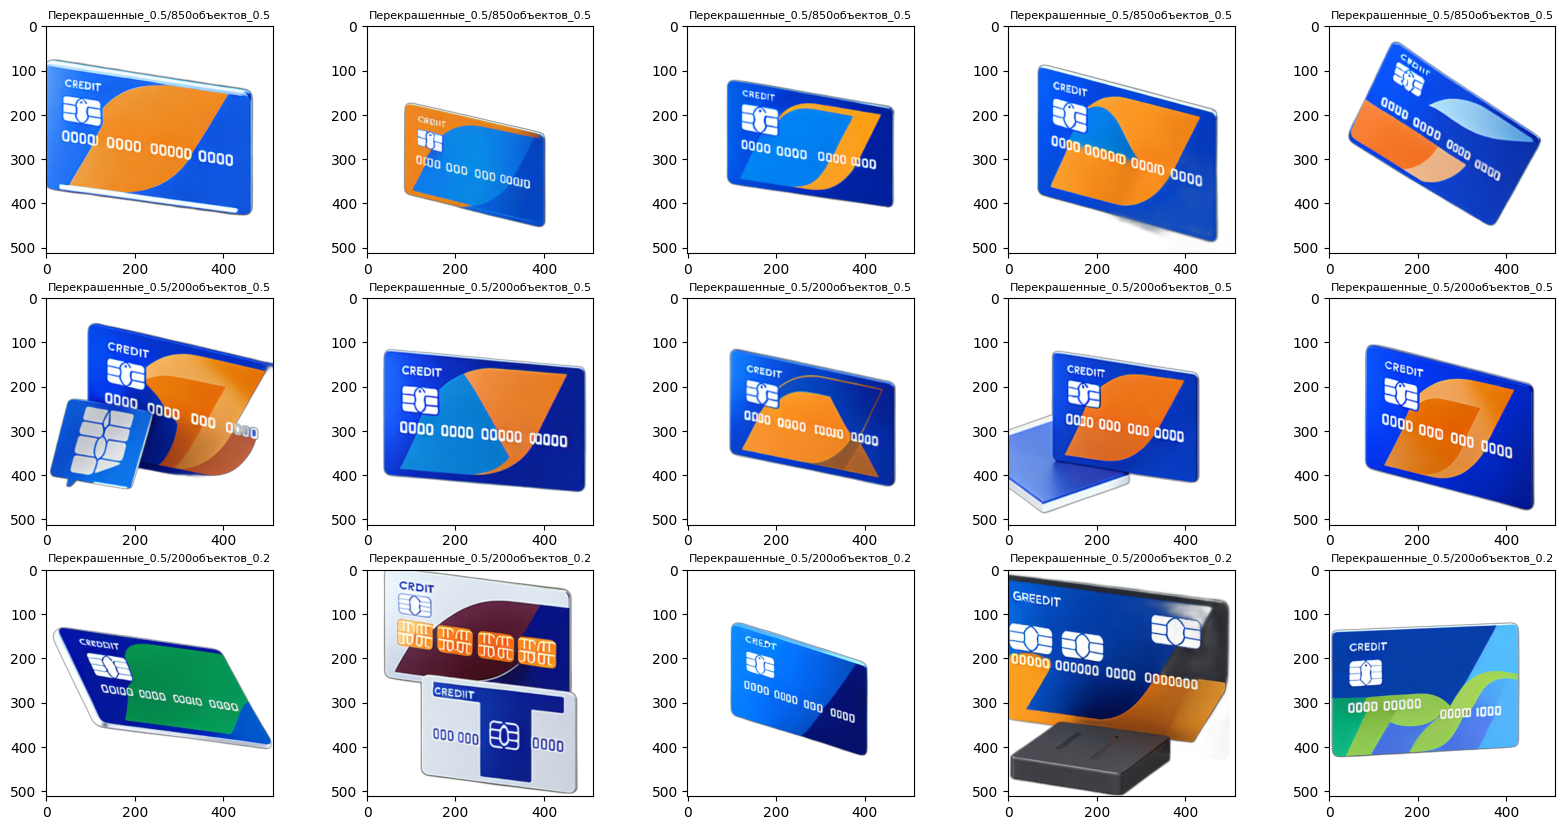

In [46]:
n = 5
prompt='credit card'

list_gen_imgs, labels = make_photo(dict_request, prompt, n)
plot_imgs(list_gen_imgs, labels, n)

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

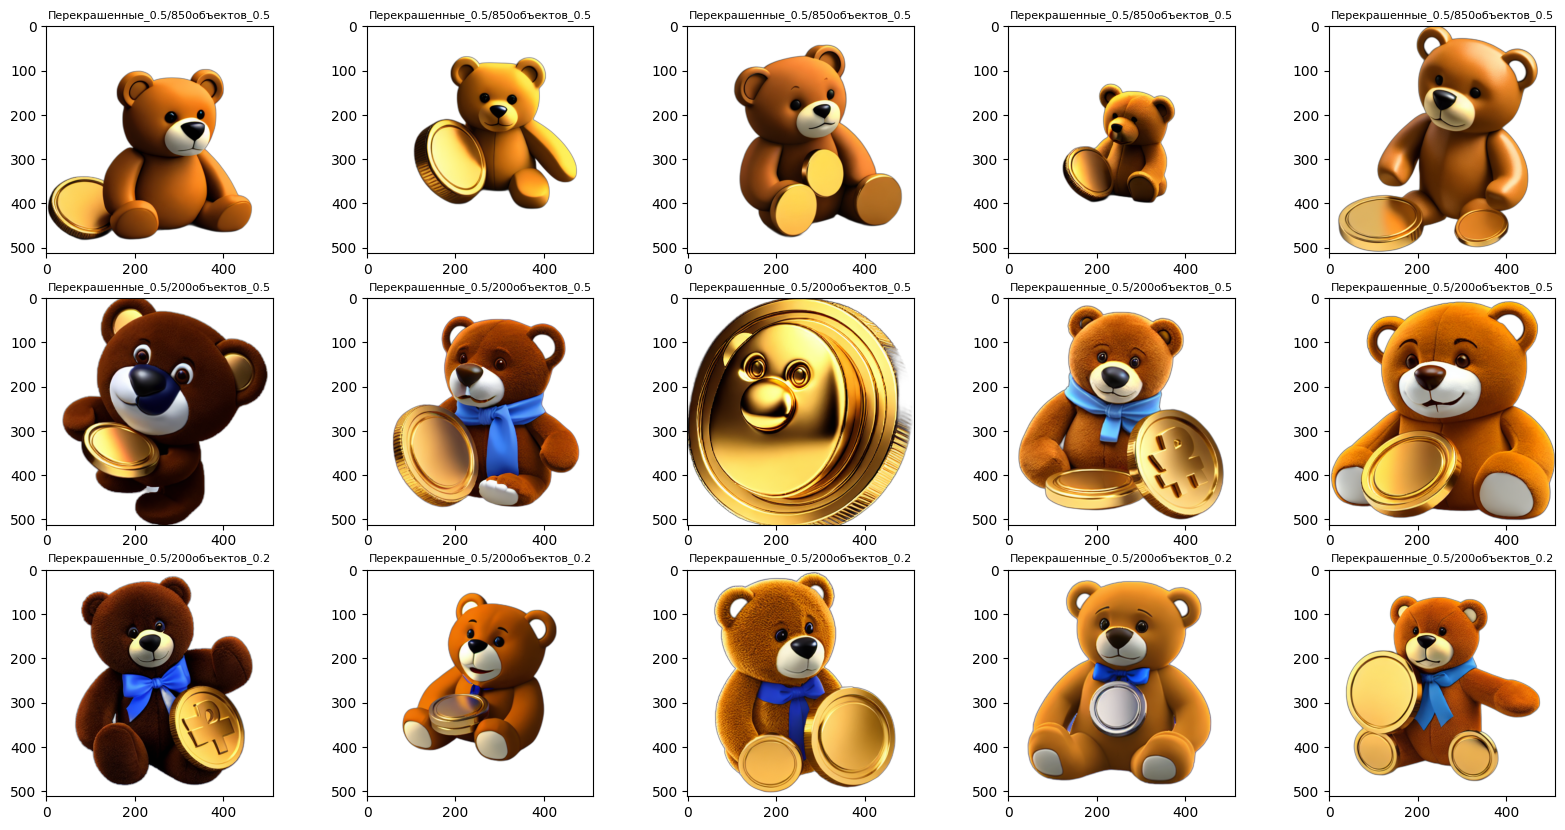

In [47]:
n = 5
prompt='мишка с монетой'

list_gen_imgs, labels = make_photo(dict_request, prompt, n)
plot_imgs(list_gen_imgs, labels, n)

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

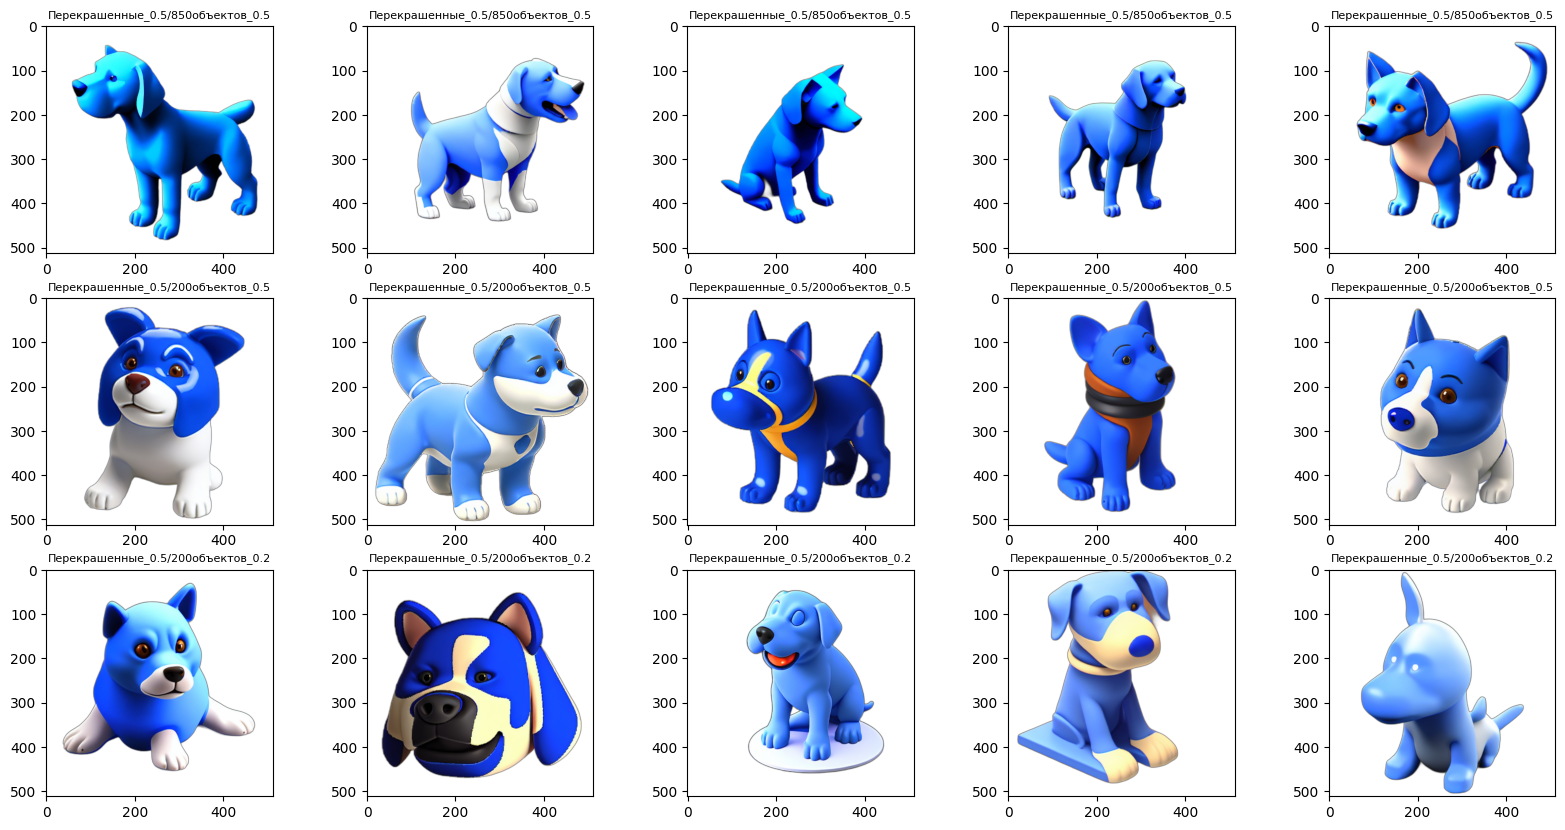

In [37]:
n = 5
prompt='голубая собака'
list_gen_imgs, labels = make_photo(dict_request, prompt, n)
plot_imgs(list_gen_imgs, labels, n)

  0%|          | 0/50 [00:00<?, ?it/s]

100%|████████████████████████████████████████| 176M/176M [00:00<00:00, 234GB/s]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

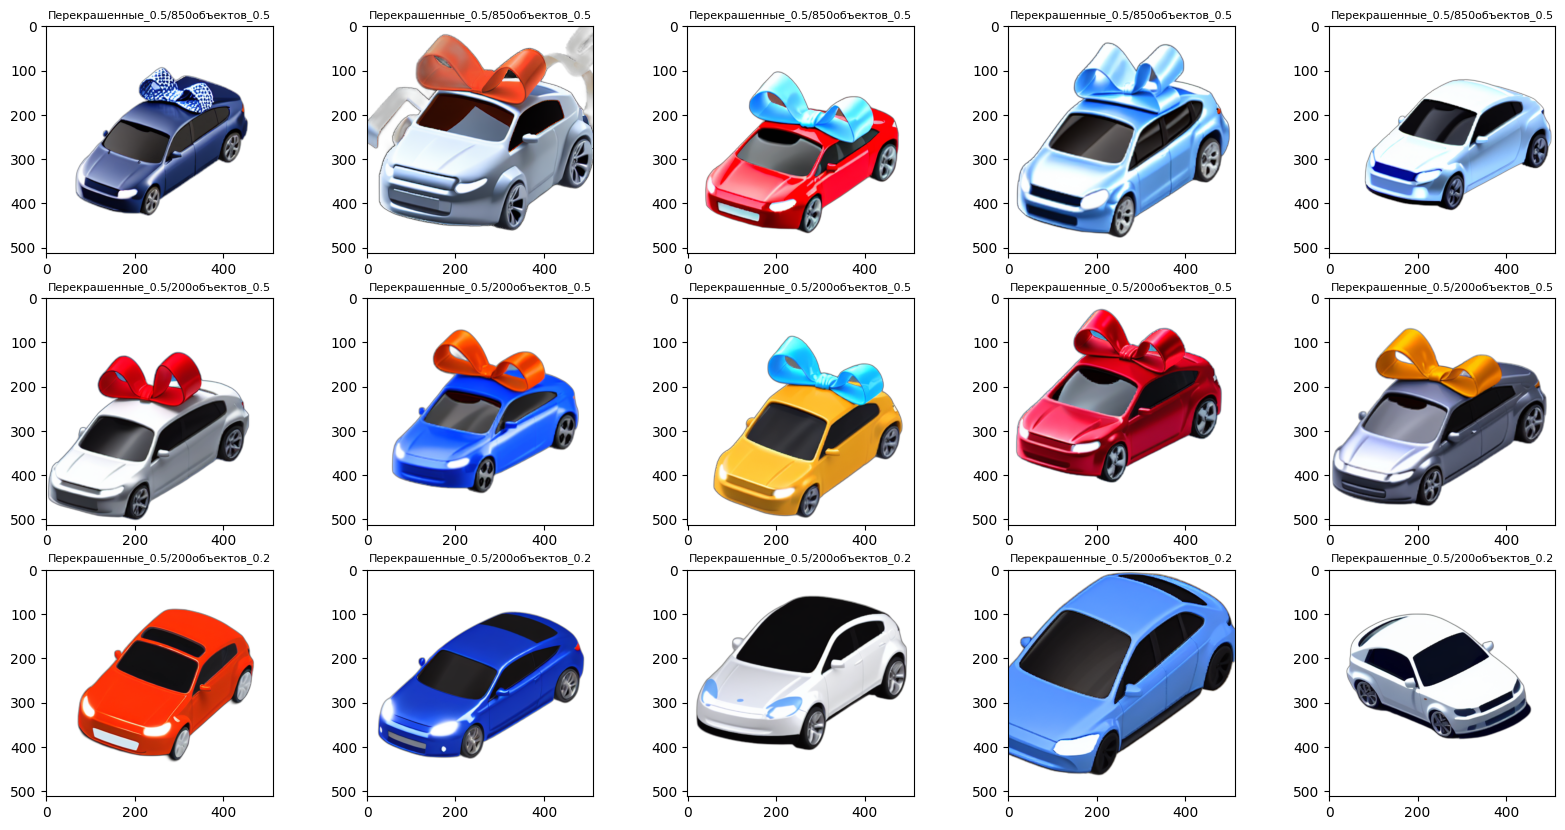

In [8]:
n = 5
prompt='машина с бантом'
list_gen_imgs, labels = make_photo(dict_request, prompt, n)
plot_imgs(list_gen_imgs, labels, n)